# Homework 5

In this homework, you'll review some linear algebra, and practice using `sklearn` and `scipy.optimize` to solve several variations of linear models.  You'll also use Pandas and Scikit learn for a simple machine learning task on a UCI data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
import sklearn

## Linear Models

A standard problem in statistics to solve the multivariate linear regression problem.
\begin{equation}
y = X * \beta + \epsilon
\end{equation}
The above notation is standard in statistics, but we'll use Householder notation by replacing $\beta$ with `b`
```
y = X * b + eps
```
`X` is known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix), and consists of `n` rows of observations, each of which has `p` features.  `y` is a vector of `n` responses.  `b` is an unknown vector of `p` coefficients which we would like to find.  `eps` (epsilon) is a vector of length `n` with random noise, typically i.i.d. normally distributed with variance `sig` (sigma).

In numpy notation, we could express this as
```python
y[i] = np.dot(X[i], b) + sig * np.random.randn()
```

We want to determine `b`, so that when me make a new observation `X[n]` we can predict the response `y[n]`.  Our goal is to minimize the mean square error

\begin{equation}
\mathop{\mathsf{minimize}}_b \mathbb{E}((X[n]*b - y[n])^2)
\end{equation}

The solution to this is the solution to the least squares problem
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X*b - y\|_2^2
\end{equation}

Where $n$ is the number of rows in $X$.  We'll let the solution to the problem be denoted $\hat{b}$, or `bhat`.

## Problem 0 - Linear Regression (30 points)

There are a variety of ways to solve the above problem.  We'll assume that $n > p$, meaning there are more observations than features.

### Generating Data

Write a function `gen_lstsq(n, p, sig=0.1)` which will generate a linear least squares problem (return `X`, `y`, and `b` as described above).  `b` is the "ground truth" coefficients that we are looking for.  You can generate the matrix `X` using `np.random.randn`, and generate `b` using `np.random.randn` as well.


In [2]:
## Your code here
def gen_lstsq(n, p, sig = 0.1):
    """
    returns the design matrix X, vectors y and b that can be used for a linear least squares problem
    """
    X = np.random.randn(n, p) # n\times p design matrix
    b = np.random.randn(p) # p\times 1 vector of coefficient parameters
    eps = np.random.randn(n) # n\times 1 vector of random noise
    y = X @ b + eps
    return X, y, b

### QR factorization

If we form a QR factorization $X = QR$, we can find $\hat{b} = R^{-1} Q^T y$.

Write a function `solve_lstsq_qr(X, y)` which estimates `b` using the QR factorization as above.

In [3]:
## Your code here
def solve_lstsq_qr(X, y):
    """
    returns bhat for least squares problem using QR factorization
    """
    Q, R = la.qr(X, mode = "economic") # (economic) QR decomposition
    bhat = la.solve_triangular(R, Q.T @ y, lower=False) # R is an upper triangular matrix
    return bhat

### Normal Equations

Often, this is the way statistics textbooks solve the problem: $\hat{b} = (X^T X)^{-1} X^T y$.  This is based on the normal equation $X^T X \hat{b} = X^T y$.

Write a function `solve_lstsq_normal(X, y)` which estimates `b` using the normal equations above.  You probably don't want to form the inverse - use an LU or Cholesky factorization instead.

In [4]:
## Your code here
def solve_lstsq_normal(X, y):
    """
    returns bhat for least squares problem using normal equation
    """
    bhat = la.solve(X.T @ X, X.T @ y) # the default solver uses LU factorization
    return bhat

### Check Your Work

Generate a few random problems to test that `solve_lstsq_qr` and `solve_lstsq_normal` give the same prediction $\hat{b}$ (measure $\|\hat{b}_{qr} - \hat{b}_{normal}\|_2$ and check it is smaller than `1e-4`).  Use $n > p$.  Check against `solve_lstsq` in numpy or scipy as well.

In [5]:
## Your code here
X, y, b = gen_lstsq(100, 50, sig = 0.05) # Generate a least squares problem
bhat_qr = solve_lstsq_qr(X, y) # Solve for bhat using QR
bhat_normal = solve_lstsq_normal(X, y) # Solve for bhat using normal equation
bhat_default = np.linalg.lstsq(X, y, rcond = None)[0] # Solve for bhat using default scipy solve_lstsq

# Checking each estimate against each other
np.array([la.norm(bhat_qr - bhat_normal), la.norm(bhat_qr - bhat_default), la.norm(bhat_normal - bhat_default)])

array([8.75627003e-15, 1.60305199e-14, 1.59706007e-14])

I confirm that all three methods are equivalent to machine precision.

### Estimate the Mean Squared Error

Write a function `mse` which estimates the mean squared error (MSE) $\mathbb{E}[\|X * \hat{b} - y\|_2^2]$.

The function should have the call signature `mse(b, bhat, N=100, sig=0.1)`  You can generate `X` to be `N x p` using `np.random.randn`, and set `y = X * b + sig * np.random.randn(p)` (use the same value of `sig` that you use when generating the data).  You can then estimate the MSE by computing $\frac{1}{N}\|X * \hat{b} - y\|_2^2$

Create a plot of the MSE vs the noise parameter `sig` (use the same value of `sig` when generating data and computing the MSE).  Put `sig` on a logartihmic axis ranging from `1e-4` to `10`.  Use `n=100`, `p=50` when generating data, and `N=100` when computing the MSE.  Put your plot on log-log axes.  Give it a title and axis labels.

In [6]:
## Your code here
def mse(b, bhat, N = 100, sig = 0.1):
    """
    returns the mean squared error given b and bhat
    """
    p = len(b) # extract the dimension of b
    X = np.random.randn(N, p) # generate a random n\times p matrix
    y = X @ b + sig * np.random.randn(N) # generate a random response vector y
    mse = ((la.norm(X @ bhat - y)) ** 2) / N # calculate mean squared prediction error
    return mse

In [7]:
n = 100
p = 50
sigs = np.linspace(1e-4, 10, 1000) # create a sequence of values for sig
mses = [] # a list to capture the MSE values
for sig in sigs:
    X, y, b = gen_lstsq(n, p, sig) # generate least squares problems for each level of sig
    bhat_qr = solve_lstsq_qr(X, y) # solve using solve_lstsq_qr
    mses.append(mse(b, bhat_qr, sig = sig)) # append the values to a list

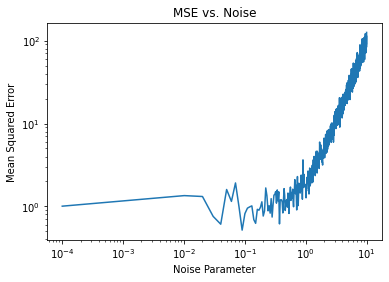

In [8]:
# Creating the plot
plt.loglog(sigs, mses)
plt.title("MSE vs. Noise")
plt.xlabel("Noise Parameter")
plt.ylabel("Mean Squared Error")
plt.show()

The mean squared prediction errors increase sharply with the size of the noise parameter. This is intuitive, since it will be more difficult to predict a noisier response value.

### Discussion 1

Which of `solve_lstsq_qr` and `solve_lstsq_normal` is faster?  Give a justification for your answer (e.g. in terms of what you know about time to compute matrix multiplication and factorizations).

In [9]:
## Your code here
from time import time

# Generate new X, y
X, y, b = gen_lstsq(100, 50, sig = 0.5)

# Runtime for solve_lstsq_qr
t0_qr = time()
bhat_qr = solve_lstsq_qr(X, y)
t1_qr = time()
print("solve_lstsq_qr: {} sec.".format(t1_qr - t0_qr))

# Runtime for solve_lstsq_normal
t0_normal = time()
bhat_normal = solve_lstsq_normal(X, y)
t1_normal = time()
print("solve_lstsq_normal: {} sec.".format(t1_normal - t0_normal))

solve_lstsq_qr: 0.0015058517456054688 sec.
solve_lstsq_normal: 0.0009870529174804688 sec.


---
`solve_lstsq_normal` uses LU factorization to solve the linear system, whereas `solve_lstsq_qr` uses QR factorization. LU factorization and QR factorization both have computational complexity of $O(n^3)$, but LU factorization is slightly faster, with $O(\frac{2}{3}n^3)$. This is probably why `solve_lstsq_normal` is a little better than `solve_lstsq_qr`.

### Optimization

Solve the minimization problem 
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2
\end{equation}

using `scipy.optimize.minimize`.  Wrap this in a function `solve_lstsq_opt(X, y)`.  Note that you can define the objective function inside `solve_lstsq_opt`

**Jacobian**: you should implement the Jacobian of the objective function to use in the optimization problem.  Here's a derivation:  We'd like to minimize the objective function
\begin{equation}
n f(b) = \|X*b - y\|_2^2 = (Xb - y)^T (Xb - y) = b^T X^T X b - 2 y^T X b + y^T y
\end{equation}

We might write the above expression as
\begin{equation}
n f(b) \sum_{i,j} b_i (X^T X)_{i,j} b_j - 2\sum_{j,i} y_i X_{i,j} b_j + y^T y
\end{equation}

We can take a derivative with respect to $b_j$
\begin{equation}
n \frac{\partial f}{\partial b_j} = \sum_{i\ne j} b_i (X^T X)_{i,j} + \sum_{i\ne j} (X^T X)_{j,i} b_i + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}
\end{equation}

Putting this in matrix form, we obtain
\begin{equation}
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X
\end{equation}

So we can write $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$

In [10]:
## Your code here
from scipy.optimize import minimize
def solve_lstsq_opt(X, y):
    """
    returns the least squares solution using scipy.optimize.minimize
    """
    n = len(y) # extract dimension of y
    p = X.shape[1] # extract dimension of b
    
    def obj_fun(b):
        """
        the objective function to minimize
        """
        return (1 / n) * (la.norm(X @ b - y))**2
    
    def jacobian(b):
        """
        the Jacobian of the objective function
        """
        return (2 / n) * (b.T @ (X.T @ X) - y.T @ X) # Jacobian from the above derivation
    
    x0 = np.zeros(p) # set the initial guess as the zero vector
    bhat = minimize(obj_fun, x0, jac = jacobian).x # extract bhat from scipy.optimize.minimize
    return bhat

#### Check Your Work

Generate a few random problems to test that `solve_lstsq_opt` agrees with `solve_lstsq_qr` and `solve_lstsq_normal` in part A.  Use the same tolerance for checking.

In [11]:
## Your code here
def solve_test(solve1, solve2, n, p, m, tol = 1e-4):
    """
    returns boolean indicators checking for equivalence of the bhats using different methods
    
    Parameters:
    solve1, solve2: functions (or methods) to be compared
    n : number of observations
    p : number of parameters
    m : number of tests to run
    tol : tolerance level of the test
    """
    test_result = [] # a list to capture the test results
    for i in range(m):
        X, y, b = gen_lstsq(n, p) # generate a least squares problem
        bhat1 = solve1(X, y) # solve for bhat using solve1
        bhat2 = solve2(X, y) # solve for bhat using solve2
        test = (la.norm(bhat1 - bhat2) < tol) # output True if the difference is less than the tolerance level
        test_result.append(test) # append test results to a list
    return test_result

In [12]:
# Testing solve_lstsq_opt against solve_lstsq_qr
solve_test(solve_lstsq_opt, solve_lstsq_qr, 100, 50, 10, tol = 1e-4)

[True, True, True, True, True, True, True, True, True, True]

In [13]:
# Testing solve_lstsq_opt against solve_lstsq_normal
solve_test(solve_lstsq_opt, solve_lstsq_normal, 100, 50, 10, tol = 1e-4)

[True, True, True, True, True, True, True, True, True, True]

----
The tests indicate that the methods are all equivalent to machine precision.

### Discussion 2

How fast is `solve_lstsq_opt` compared to the functions you wrote in part A?  Give some justification for what you see.

In [14]:
## Your code here
# Generate new X, y
X, y, b = gen_lstsq(100, 50, sig = 0.5)

# Runtime for solve_lstsq_qr
t0_qr = time()
bhat_qr = solve_lstsq_qr(X, y)
t1_qr = time()
print("solve_lstsq_qr: {} sec.".format(t1_qr - t0_qr))

# Runtime for solve_lstsq_normal
t0_normal = time()
bhat_normal = solve_lstsq_normal(X, y)
t1_normal = time()
print("solve_lstsq_normal: {} sec.".format(t1_normal - t0_normal))

# Runtime for solve_lstsq_opt
t0_opt = time()
bhat_opt = solve_lstsq_opt(X, y)
t1_opt = time()
print("solve_lstsq_opt: {} sec.".format(t1_opt - t0_opt))

solve_lstsq_qr: 0.002273082733154297 sec.
solve_lstsq_normal: 0.0012238025665283203 sec.
solve_lstsq_opt: 0.018990278244018555 sec.


---

`solve_lstsq_opt` is lot slower compared to the other two. This method is also based on matrix multiplications, which means it must also be of complexity $O(n^3)$. The documentation for `scipy.optimize.minimize` cites that it uses the **Nelder-Mead algorithm** as the default when given a Jacobian parameter. It seems to involve computing matrix multiplications multiple times, which yields a much slower running time compared to methods based on LU or QR factorizations.

### Scikit Learn

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to solve the linear regression problem. You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `LinearRegression` instead of a `solve_lstsq` function.  Set the keyword `fit_intercept=False`.

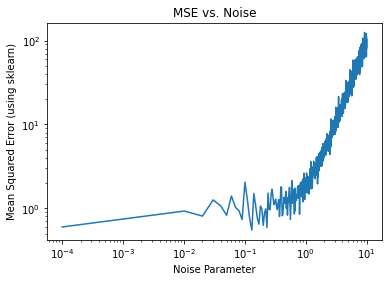

In [15]:
## Your code here
from sklearn.linear_model import LinearRegression

n = 100
p = 50
sigs = np.linspace(1e-4, 10, 1000) # create a sequence of values for sig
mses_sklearn = []
for sig in sigs:
    X, y, b = gen_lstsq(n, p, sig) # generate least squares problems for each level of sig
    bhat_sklearn = LinearRegression(fit_intercept = False).fit(X, y).coef_ # solve using sklearn
    mses_sklearn.append(mse(b, bhat_sklearn, sig = sig)) # append the values to a list
    
# Creating the plot
plt.loglog(sigs, mses_sklearn)
plt.title("MSE vs. Noise")
plt.xlabel("Noise Parameter")
plt.ylabel("Mean Squared Error (using sklearn)")
plt.show()

The mean squared prediction errors for `LinearRegression` seems to behave similarly to previously defined methods based on matrix decomposition.

## Problem 1 - Ridge Regression (15 points)

We'll now turn to the problem of what to do when `n < p` (there are fewer observations than features).  In this case we can solve $X * b = y$ exactly, but there are many possible values of $b$ which can satisfy the equation.

The normal equations are singular, and the $R$ term of the QR factorization is not invertible in this case.  We need to do something else.

Ridge regression seeks to solve the following optimization problem:

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2 + \lambda \|b\|_2^2
\end{equation}

$\lambda$ is a parameter you can choose to "regularize" the problem which you can choose.

### Optimization

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_ridge_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2
\end{equation}

---

Note that the Jacobian we obtained from Problem 0 for $\|X*b - y\|_2^2$ was
$$J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$$

Also note that
$$\frac{\partial}{\partial b} (\lambda b^T b) = 2\lambda b^T$$

Thus, the Jacobian of the objective function for ridge regression is the sum of the two above.
$$ \Rightarrow J_{Ridge}(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X + 2\lambda b^T $$

In [16]:
## Your code here
def solve_ridge_opt(X, y, lam = 0.1):
    """
    returns the solution to ridge regression using scipy.optimize.minimize
    """
    n = len(y) # extract dimension of y
    p = X.shape[1] # extract dimension of b
    
    def obj_fun_ridge(b):
        """
        the objective function to minimize
        """
        return (1 / n) * (la.norm(X @ b - y))**2 + lam * (la.norm(b))**2
    
    def jacobian_ridge(b):
        """
        the Jacobian of the objective function
        """
        return (2 / n) * (b.T @ (X.T @ X) - y.T @ X) + 2 * lam * b.T # Jacobian from the above derivation
    
    x0 = np.zeros(p) # set the initial guess as the zero vector
    bhat = minimize(obj_fun_ridge, x0, jac = jacobian_ridge).x # extract bhat from scipy.optimize.minimize
    return bhat

### Compute the MSE

Set `n = 50`, `p=100`, and `sig=0.1`.  Make a plot that displays the MSE of `bhat` computed using `solve_ridge_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

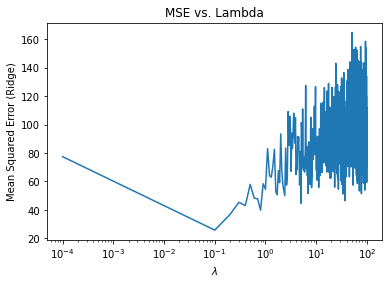

In [17]:
## Your code here
n = 50
p = 100
lams = np.linspace(1e-4, 1e2, 1000) # create a sequence of values for lambda
mses_ridge_opt = [] # a list to capture the MSE values
for lam in lams:
    X, y, b = gen_lstsq(n, p) # generate a least squares problem
    bhat_ridge_opt = solve_ridge_opt(X, y, lam = lam) # solve for bhat using each value of lambda
    mses_ridge_opt.append(mse(b, bhat_ridge_opt)) # append the values to a list
    
# Creating the plot
plt.semilogx(lams, mses_ridge_opt)
plt.title("MSE vs. Lambda")
plt.xlabel("$\lambda$")
plt.ylabel("Mean Squared Error (Ridge)")
plt.show()

The mean squared prediction errors increase with the level of $\lambda$ and appears quite unstable. This is expected, given that higher values of $\lambda$ will introduce more bias to the coefficient estimates in ridge regression.

### Scikit Learn

Use [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) to solve the Ridge regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Ridge` instead of your `solve_ridge_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

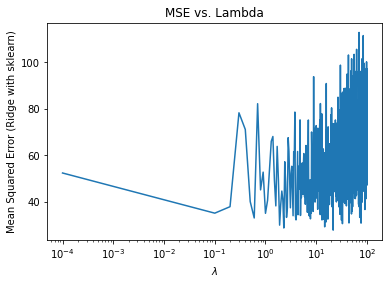

In [18]:
## Your code here
from sklearn.linear_model import Ridge

n = 50
p = 100
lams = np.linspace(1e-4, 1e2, 1000) # create a sequence of values of lambda
mses_ridge_sklearn = [] # a list to capture the MSE values
for lam in lams:
    X, y, b = gen_lstsq(n, p) # generate a least squares problem
    bhat_ridge_sklearn = Ridge(alpha = lam, fit_intercept = False).fit(X, y).coef_ # solve for bhat using sklearn
    mses_ridge_sklearn.append(mse(b, bhat_ridge_sklearn)) # append the MSE value to the list
    
# Creating the plot
plt.semilogx(lams, mses_ridge_sklearn)
plt.title("MSE vs. Lambda")
plt.xlabel("$\lambda$")
plt.ylabel("Mean Squared Error (Ridge with sklearn)")
plt.show()

The ridge regression contained in `sklearn` behaves similarly to the one defined based on `scipy.optimize.minimize`.

## Problem 2 - Lasso (15 points)

The Lasso is L1-regularized regression.  This is often used when `p > n`, and when the parameter vector `b` is assumed to be sparse, meaning that it has few non-zero entries.

The minimization problem is
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Where again, $\lambda$ can be chosen.

### Generate Data

We need to modify our generation of data to produce sparse `b`.  Write a function `gen_lstsq_sparse(n, p, sig=0.1, k=10)`, which generates `X` and `y` in the same way as `gen_lstsq`, but now `b` is generated to be a vector of length `p` with `k` random entries set to 1, and all other entries set to 0. Hint: look at `np.random.choice` for generating `k` random integers without replacement.

In [19]:
## Your code here
def gen_lstsq_sparse(n, p, sig = 0.1, k = 10):
    """
    returns the design matrix X, vectors y and b that can be used for a linear least squares problem
    with b as a sparse vector k non-zero entries
    """
    X = np.random.randn(n, p) # n\times p design matrix
    nonzeros = np.random.choice(p, k) # randomly choose k indices out of p to set as 1
    b = np.zeros(p) # a vector of zeros
    for i in range(p):
        if i in nonzeros:
            b[i] = 1 # if the index is in 'zeros', then set the entry as one
    eps = np.random.randn(n) # n\times 1 vector of random noise
    y = X @ b + eps # create y
    return X, y, b

### Optimization

Recall we want to find `bhat` to solve
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_lasso_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_1 = \lambda \sum_i |b_i|
\end{equation}

If $b_i$ is zero, then take $\partial_i |b_i| = 0$ (this is in the [subgradient](https://en.wikipedia.org/wiki/Subderivative)). Hint 2: look at `np.sign` for implementation

---

Note that the Jacobian we obtained from Problem 0 for $\|X*b - y\|_2^2$ was
$$J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$$

Also note that
$$\frac{\partial}{\partial b} (\lambda |b|) = \lambda * sgn(b^T)$$

Thus, the Jacobian of the objective function for ridge regression is the sum of the two above.
$$ \Rightarrow J_{Lasso}(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X + \lambda * sgn(b^T) $$

In [20]:
## Your code here
def solve_lasso_opt(X, y, lam = 0.1):
    """
    returns the solution to ridge regression using scipy.optimize.minimize
    """
    n = len(y) # extract the dimension of y
    p = X.shape[1] # extract the dimension of b
    
    def obj_fun_lasso(b):
        """
        the objective function to minimize
        """
        return (1 / n) * (la.norm(X @ b - y))**2 + lam * la.norm(b, ord = 1)
    
    def jacobian_lasso(b):
        """
        the Jacobian of the objective function
        """
        return (2 / n) * (b.T @ (X.T @ X) - y.T @ X) + lam * np.sign(b.T) # Jacobian from the above derivation
    
    x0 = np.zeros(p) # set the initial guess as the zero vector
    bhat = minimize(obj_fun_lasso, x0, jac = jacobian_lasso).x # solve for bhat using scipy.optimize.minimize
    return bhat

### Compute the MSE

Set `n = 50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  Make a plot that displays the MSE of `bhat` computed using `solve_lasso_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

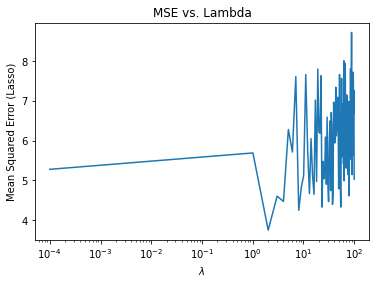

In [21]:
## Your code here
n = 50
p = 100
lams = np.linspace(1e-4, 1e2, 100) # create a sequence of values for lambda
mses_lasso_opt = [] # a list to capture the MSE values
for lam in lams:
    X, y, b = gen_lstsq_sparse(n, p, sig = 0.1, k = 10) # generate a sparse least squares problem
    bhat_lasso_opt = Ridge(alpha = lam, fit_intercept = False).fit(X, y).coef_ # solve for bhat using sklearn
    mses_lasso_opt.append(mse(b, bhat_lasso_opt)) # append the MSE value to the list
    
# Creating the plot
plt.semilogx(lams, mses_lasso_opt)
plt.title("MSE vs. Lambda")
plt.xlabel("$\lambda$")
plt.ylabel("Mean Squared Error (Lasso)")
plt.show()

The mean squared prediction errors increase with higher levels of $\lambda$. Again, as with ridge regression, lasso also introduces more bias to the coefficient estimates as $\lambda$ gets larger. However, the scale of the errors are much less than in the models we have seen above. Note that our ground truth is a sparse vector of coefficients. As lasso favors sparsity by design, it may be more accurate in practice.

### Scikit Learn

Use [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) to solve the Lasso regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Lasso` instead of your `solve_lasso_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07058695032986691, tolerance: 0.05193593521936694
  model = cd_fast.enet_coordinate_descent(


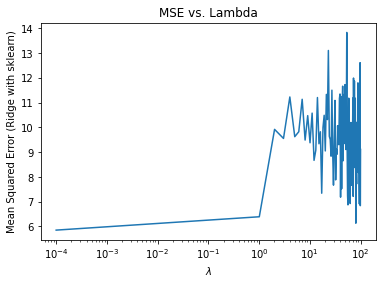

In [22]:
## Your code here
from sklearn.linear_model import Lasso

n = 50
p = 100
lams = np.linspace(1e-4, 1e2, 100) # create a sequence of values for lambda
mses_lasso_sklearn = [] # the list to capture the MSE values
for lam in lams:
    X, y, b = gen_lstsq_sparse(n, p, sig = 0.1, k = 10) # generate a sparse least squares problem
    bhat_lasso_sklearn = Lasso(alpha = lam, fit_intercept = False).fit(X, y).coef_ # solve for bhat using sklearn
    mses_lasso_sklearn.append(mse(b, bhat_lasso_sklearn)) # append the MSE value to the list
    
# Creating the plot
plt.semilogx(lams, mses_lasso_sklearn)
plt.title("MSE vs. Lambda")
plt.xlabel("$\lambda$")
plt.ylabel("Mean Squared Error (Ridge with sklearn)")
plt.show()

Lasso function within `sklearn` does not deviate much from the function I defined based on `scipy.optimize.minimize`, although the scale of the errors are slightly larger.

## Problem 3 - Elastic Net (20 points)

Another option when `p > n` is the [Elastic Net]() which combines L1 and L2 regularization.

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda_1 \|b\|_1 + \lambda_2 \|b\|_2^2
\end{equation}
Where we get to choose $\lambda_1$ and $\lambda_2$.

You can find a function that does this in [`sklearn.linear_model.ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

In this problem, you'll write a class that emulates the behavior of a Scikit learn class. Use `scipy.optimize.minimize` to solve the optimization problem.


### Jacobian

Give an expression for the Jacobian for the optimization objective function.  You've already done all the hard work for this in problems 1 and 2

---

Note that the Jacobian for Elastic Net is just a combination of the Jacobian for Lasso and Ridge, replacing $\lambda$ in each case with $\lambda_1$ and $\lambda_2$, respectively. That is,

$$J_{EN}(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X + \lambda_1 * sgn(b^T) + 2\lambda_2 b^T$$

### Write the Class

Define a Python Class `ElasticNet`.  When you initialize the class you should be able to provide keyword arguments `lam1` for $\lambda_1$ and `lam2` for $\lambda_2$.  Give each these keyword arguments a default value of `0.5`.

In addition to `__init__`, your class should provide two methods:
1. `fit(X, y)` - sets an attribute `bhat` which solves the optimization problem (use the parameters `lam1` and `lam2` provided in initialization).  Use `scipy.optimize.minimize`
2. `predict(X)` - predict values of `y` as `X @ bhat`

In [23]:
## Your code here
class ElasticNet:
    """
    class definition for Elastic Net
    """
    def __init__(self, X, y, lam1 = 0.5, lam2 = 0.5):
        """
        initialization
        """
        self.X = X # get X
        self.y = y # get Y
        self.lam1 = lam1 # get lambda1
        self.lam2 = lam2 # get lambda2
        self.n = len(self.y) # extract dimension of y
        self.p = self.X.shape[1] # extract dimension of b
    
    def fit(self, X, y):
        """
        method for fitting an Elastic Net
        """
        n = self.n
        p = self.p
        x0 = np.zeros(p)
        lam1 = self.lam1
        lam2 = self.lam2
        
        def obj_fun_en(b):
            """
            the objective function to minimize
            """
            return (1 / n) * (la.norm(X @ b - y))**2 + lam1 * (la.norm(b, ord = 1)) + lam2 * (la.norm(b))**2
    
        def jacobian_en(b):
            """
            the Jacobian of the objective function
            """
            return (2 / n) * (b.T @ (X.T @ X) - y.T @ X) + lam1 * np.sign(b.T) + 2 * lam2 * b.T # Jacobian derived
        
        self.bhat = minimize(obj_fun_en, x0, jac = jacobian_en).x
        return self.bhat
    
    def predict(self, x):
        return x @ self.fit(X, y)

### Compute the MSE

Set `n=50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  

Set `n=50`, `p=100`, and `sig=0.1` to generate a problem using `gen_lstsq`.

Make a plot that displays the MSE of the model computed using your `ElasticNet` class using `lam1=lam2` varying between `1e-4` and `1e2` for each of the generated problems (your plot should have 2 lines).  Give your plot a title, axis labels, and a legend.

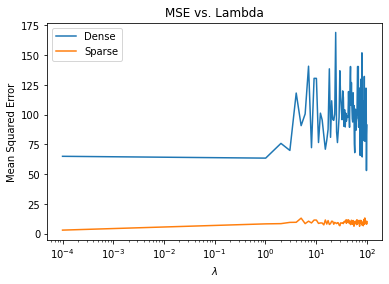

In [27]:
n = 50
p = 100
lams = np.linspace(1e-4, 1e2, 100) # create a sequence of values for lambda
mses_elastic_net = [] # a list to capture MSEs for elastic net (dense case)
for lam in lams:
    X, y, b = gen_lstsq(n, p, sig = 0.1) # generate a least squares problem
    bhat_elastic_net = ElasticNet(X, y, lam1 = lam, lam2 = lam).fit(X, y) # solve for bhat using sklearn
    mses_elastic_net.append(mse(b, bhat_elastic_net)) # append MSE value to the list

mses_elastic_sparse = [] # a list to capture MSEs for elastic net (sparse case)
for lam in lams:
    X, y, b = gen_lstsq_sparse(n, p, sig = 0.1, k = 10) # generate a sparse least squares problem
    bhat_elastic_sparse = ElasticNet(X, y, lam1 = lam, lam2 = lam).fit(X, y) # solve for bhat using sklearn
    mses_elastic_sparse.append(mse(b, bhat_elastic_sparse)) # append MSE value to the list

# Creating the plot
plt.semilogx(lams, mses_elastic_net, label = "Dense")
plt.semilogx(lams, mses_elastic_sparse, label = "Sparse")
plt.title("MSE vs. Lambda")
plt.xlabel("$\lambda$")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

I discover that using an Elastic Net, a combination of ridge and lasso, is very powerful when we are predicting a sparse model. The dense case is much more erroneous, since the lasso component will strongly favor sparsity and incorrectly render coefficients to zero.

## Problem 4 - Real Data (20 points)

In this problem you'll use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/).  We'll focus on the red wines found in [`winequality-red.csv`](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv).  The goal is to train a machine learning model that will predict the wine quality from a variety of other features.

### Load the data set

Load the wines in `windquality-red.csv` into a Pandas data frame. Note that this file has column labels, which are interpreted in the data set documentation:

Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

Note that this file uses semi-colons `;` to delimit values.  You can use `delimiter=';'` as a keyword argument.

In [28]:
## Your code here
wine = pd.read_csv("winequality-red.csv", delimiter = ";") # read in the data
wine.head() # an initial look

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [29]:
# Setting design matrix X and response vector y
X = wine.iloc[:, :-1] # design matrix (the first 11 columns)
y = wine.iloc[:, -1] # response vector (the 11th column)

The first 11 columns will be features for the model (used in the design matrix `X`), and the last column (quality) is the quantity we're tyring to predict (the response `y`).

### Split the Data in to Training and Testing Sets

Split the data `X, y` into `X_train, y_train, X_test, y_test` using `sklearn`.  Use 70% of the data for training, and 30% of the data for testing.


In [30]:
## Your code here
from sklearn.model_selection import train_test_split
# Split the data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Train a Model and Measure Error

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to fit a linear regression model to your training data.

Use [`sklearn.metrics.mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) to compute the MSE on your test set.

In [31]:
## Your code here
from sklearn.metrics import mean_squared_error
regression_model = LinearRegression(fit_intercept = False).fit(X, y) # fit a linear regression
y_pred = X_test @ regression_model.coef_ # predictions on the test set
mean_squared_error(y_test, y_pred) # mean squared errors for the prediction

0.44910067105336665

The trained model seems to be pretty good at predicting the response.